[View in Colaboratory](https://colab.research.google.com/github/karangautam/Learning-Samples/blob/master/Stock_Predict_multivariable_LSTM.ipynb)

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [2]:
import numpy as np
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [4]:
!pip install quandl

    100% |████████████████████████████████| 51kB 5.8MB/s 
    100% |████████████████████████████████| 61kB 11.4MB/s 
    100% |████████████████████████████████| 2.2MB 10.2MB/s 
    100% |████████████████████████████████| 102kB 20.2MB/s 
    100% |████████████████████████████████| 430kB 10.2MB/s 
    100% |████████████████████████████████| 256kB 19.9MB/s 
  Running setup.py bdist_wheel for inflection ... - done
  Stored in directory: /content/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
  Running setup.py bdist_wheel for pycparser ... - \ done
  Stored in directory: /content/.cache/pip/wheels/c0/a1/27/5ba234bd77ea5a290cbf6d675259ec52293193467a12ef1f46
Successfully built inflection pycparser


In [0]:
import quandl

In [0]:
%matplotlib inline

In [0]:
import matplotlib

In [0]:
df= quandl.get("NSE/EICHERMOT", authtoken="obPP_aQ1Kb_VcadQf39P")

In [0]:
df=df.dropna()

In [10]:
df.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
1998-03-24,12.15,12.15,11.3,11.30,11.40,5000.0,0.58
1998-03-25,12.00,12.55,12.0,12.35,12.35,3500.0,0.43
1998-03-26,13.50,13.50,12.7,12.75,12.75,4500.0,0.58
1998-03-27,12.50,12.80,12.5,12.75,12.75,3100.0,0.40
1998-03-30,13.00,13.20,12.5,12.50,12.70,2900.0,0.37


In [0]:
values = df.values

In [0]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [0]:
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed.head())

In [14]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.000139,0.000139,0.000117,0.000116,0.000119,0.002496,2.147534e-06,0.000135,0.000151,0.000139,0.000148,0.000148,0.001743,1.582393e-06
2,0.000135,0.000151,0.000139,0.000148,0.000148,0.001743,1.582393e-06,0.000180,0.000179,0.000160,0.000160,0.000160,0.002245,2.147534e-06
3,0.000180,0.000179,0.000160,0.000160,0.000160,0.002245,2.147534e-06,0.000150,0.000158,0.000154,0.000160,0.000160,0.001543,1.469365e-06
4,0.000150,0.000158,0.000154,0.000160,0.000160,0.001543,1.469365e-06,0.000165,0.000170,0.000154,0.000152,0.000158,0.001442,1.356337e-06
5,0.000165,0.000170,0.000154,0.000152,0.000158,0.001442,1.356337e-06,0.000127,0.000143,0.000131,0.000137,0.000137,0.002496,2.222886e-06
6,0.000127,0.000143,0.000131,0.000137,0.000137,0.002496,2.222886e-06,0.000142,0.000149,0.000142,0.000146,0.000146,0.001141,1.017253e-06
7,0.000142,0.000149,0.000142,0.000146,0.000146,0.001141,1.017253e-06,0.000129,0.000155,0.000132,0.000151,0.000151,0.000690,6.028166e-07
8,0.000129,0.000155,0.000132,0.000151,0.000151,0.000690,6.028166e-07,0.000150,0.000161,0.000143,0.000164,0.000158,0.001442,1.318661e-06
9,0.000150,0.000161,0.000143,0.000164,0.000158,0.001442,1.318661e-06,0.000145,0.000157,0.000143,0.000160,0.000158,0.001743,1.620069e-06
10,0.000145,0.000157,0.000143,0.000160,0.000158,0.001743,1.620069e-06,0.000139,0.000190,0.000143,0.000190,0.000190,0.004402,4.408096e-06


In [15]:
reframed.drop(reframed.columns[[7,8,9,10,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000139   0.000139   0.000117   0.000116   0.000119   0.002496   
2   0.000135   0.000151   0.000139   0.000148   0.000148   0.001743   
3   0.000180   0.000179   0.000160   0.000160   0.000160   0.002245   
4   0.000150   0.000158   0.000154   0.000160   0.000160   0.001543   
5   0.000165   0.000170   0.000154   0.000152   0.000158   0.001442   

   var7(t-1)   var5(t)  
1   0.000002  0.000148  
2   0.000002  0.000160  
3   0.000002  0.000160  
4   0.000001  0.000158  
5   0.000001  0.000137  


In [0]:
values=reframed.values

In [0]:
length= int(values.shape[0]*0.90)

In [0]:
train = values[:length, :]
test = values[length:, :]

In [19]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4521, 1, 7) (4521,) (503, 1, 7) (503,)


In [0]:
model = Sequential()
model.add(LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(512,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mae'])

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 512)               1064960   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 1,590,785
Trainable params: 1,590,785
Non-trainable params: 0
_________________________________________________________________


Train on 4521 samples, validate on 503 samples
Epoch 1/1000
 - 2s - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336
Epoch 2/1000
 - 2s - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.2101 - val_mean_absolute_error: 0.2101
Epoch 3/1000
 - 2s - loss: 0.0272 - mean_absolute_error: 0.0272 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376
Epoch 4/1000
 - 1s - loss: 0.0238 - mean_absolute_error: 0.0238 - val_loss: 0.1786 - val_mean_absolute_error: 0.1786
Epoch 5/1000
 - 2s - loss: 0.0169 - mean_absolute_error: 0.0169 - val_loss: 0.0490 - val_mean_absolute_error: 0.0490
Epoch 6/1000
 - 1s - loss: 0.0105 - mean_absolute_error: 0.0105 - val_loss: 0.1984 - val_mean_absolute_error: 0.1984
Epoch 7/1000
 - 2s - loss: 0.0147 - mean_absolute_error: 0.0147 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 8/1000
 - 2s - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 9/1000
 - 1

 - 2s - loss: 0.0431 - mean_absolute_error: 0.0431 - val_loss: 0.0581 - val_mean_absolute_error: 0.0581
Epoch 30/1000
 - 2s - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0996 - val_mean_absolute_error: 0.0996
Epoch 31/1000
 - 2s - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0812 - val_mean_absolute_error: 0.0812
Epoch 32/1000
 - 1s - loss: 0.0240 - mean_absolute_error: 0.0240 - val_loss: 0.0631 - val_mean_absolute_error: 0.0631
Epoch 33/1000
 - 2s - loss: 0.0161 - mean_absolute_error: 0.0161 - val_loss: 0.1292 - val_mean_absolute_error: 0.1292
Epoch 34/1000
 - 2s - loss: 0.0146 - mean_absolute_error: 0.0146 - val_loss: 0.0978 - val_mean_absolute_error: 0.0978
Epoch 35/1000
 - 2s - loss: 0.0309 - mean_absolute_error: 0.0309 - val_loss: 0.0876 - val_mean_absolute_error: 0.0876
Epoch 36/1000
 - 1s - loss: 0.0251 - mean_absolute_error: 0.0251 - val_loss: 0.0990 - val_mean_absolute_error: 0.0990
Epoch 37/1000
 - 1s - loss: 0.0227 - mean_absolute_error: 0.0227 - val

Epoch 58/1000
 - 2s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0780 - val_mean_absolute_error: 0.0780
Epoch 59/1000
 - 1s - loss: 0.0292 - mean_absolute_error: 0.0292 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352
Epoch 60/1000
 - 1s - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0460 - val_mean_absolute_error: 0.0460
Epoch 61/1000
 - 1s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0581 - val_mean_absolute_error: 0.0581
Epoch 62/1000
 - 2s - loss: 0.0231 - mean_absolute_error: 0.0231 - val_loss: 0.1330 - val_mean_absolute_error: 0.1330
Epoch 63/1000
 - 1s - loss: 0.0181 - mean_absolute_error: 0.0181 - val_loss: 0.0820 - val_mean_absolute_error: 0.0820
Epoch 64/1000
 - 2s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0523 - val_mean_absolute_error: 0.0523
Epoch 65/1000
 - 2s - loss: 0.0236 - mean_absolute_error: 0.0236 - val_loss: 0.0811 - val_mean_absolute_error: 0.0811
Epoch 66/1000
 - 1s - loss: 0.0092 - mean_absolute_error

Epoch 87/1000
 - 2s - loss: 0.0159 - mean_absolute_error: 0.0159 - val_loss: 0.0573 - val_mean_absolute_error: 0.0573
Epoch 88/1000
 - 2s - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0610 - val_mean_absolute_error: 0.0610
Epoch 89/1000
 - 1s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233
Epoch 90/1000
 - 2s - loss: 0.0109 - mean_absolute_error: 0.0109 - val_loss: 0.0626 - val_mean_absolute_error: 0.0626
Epoch 91/1000
 - 2s - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0425 - val_mean_absolute_error: 0.0425
Epoch 92/1000
 - 2s - loss: 0.0109 - mean_absolute_error: 0.0109 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 93/1000
 - 1s - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0780 - val_mean_absolute_error: 0.0780
Epoch 94/1000
 - 1s - loss: 0.0263 - mean_absolute_error: 0.0263 - val_loss: 0.0370 - val_mean_absolute_error: 0.0370
Epoch 95/1000
 - 1s - loss: 0.0124 - mean_absolute_error

Epoch 116/1000
 - 2s - loss: 0.0140 - mean_absolute_error: 0.0140 - val_loss: 0.0188 - val_mean_absolute_error: 0.0188
Epoch 117/1000
 - 2s - loss: 0.0165 - mean_absolute_error: 0.0165 - val_loss: 0.0388 - val_mean_absolute_error: 0.0388
Epoch 118/1000
 - 2s - loss: 0.0178 - mean_absolute_error: 0.0178 - val_loss: 0.0537 - val_mean_absolute_error: 0.0537
Epoch 119/1000
 - 1s - loss: 0.0165 - mean_absolute_error: 0.0165 - val_loss: 0.0251 - val_mean_absolute_error: 0.0251
Epoch 120/1000
 - 2s - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512
Epoch 121/1000
 - 1s - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0398 - val_mean_absolute_error: 0.0398
Epoch 122/1000
 - 1s - loss: 0.0190 - mean_absolute_error: 0.0190 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 123/1000
 - 1s - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 124/1000
 - 1s - loss: 0.0073 - mean_absol

 - 1s - loss: 0.0140 - mean_absolute_error: 0.0140 - val_loss: 0.0911 - val_mean_absolute_error: 0.0911
Epoch 145/1000
 - 2s - loss: 0.0170 - mean_absolute_error: 0.0170 - val_loss: 0.0669 - val_mean_absolute_error: 0.0669
Epoch 146/1000
 - 1s - loss: 0.0104 - mean_absolute_error: 0.0104 - val_loss: 0.0830 - val_mean_absolute_error: 0.0830
Epoch 147/1000
 - 2s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0370 - val_mean_absolute_error: 0.0370
Epoch 148/1000
 - 2s - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0744 - val_mean_absolute_error: 0.0744
Epoch 149/1000
 - 1s - loss: 0.0172 - mean_absolute_error: 0.0172 - val_loss: 0.0547 - val_mean_absolute_error: 0.0547
Epoch 150/1000
 - 1s - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0391 - val_mean_absolute_error: 0.0391
Epoch 151/1000
 - 1s - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239
Epoch 152/1000
 - 1s - loss: 0.0111 - mean_absolute_error: 0.01

Epoch 173/1000
 - 2s - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0130 - val_mean_absolute_error: 0.0130
Epoch 174/1000
 - 1s - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0177 - val_mean_absolute_error: 0.0177
Epoch 175/1000
 - 1s - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0138 - val_mean_absolute_error: 0.0138
Epoch 176/1000
 - 2s - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 177/1000
 - 1s - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0170 - val_mean_absolute_error: 0.0170
Epoch 178/1000
 - 2s - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0669 - val_mean_absolute_error: 0.0669
Epoch 179/1000
 - 1s - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0582 - val_mean_absolute_error: 0.0582
Epoch 180/1000
 - 1s - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0290 - val_mean_absolute_error: 0.0290
Epoch 181/1000
 - 2s - loss: 0.0058 - mean_absol

 - 2s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0197 - val_mean_absolute_error: 0.0197
Epoch 202/1000
 - 2s - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0185 - val_mean_absolute_error: 0.0185
Epoch 203/1000
 - 2s - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167
Epoch 204/1000
 - 1s - loss: 0.0069 - mean_absolute_error: 0.0069 - val_loss: 0.0294 - val_mean_absolute_error: 0.0294
Epoch 205/1000
 - 2s - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0477 - val_mean_absolute_error: 0.0477
Epoch 206/1000
 - 2s - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.0468 - val_mean_absolute_error: 0.0468
Epoch 207/1000
 - 1s - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 208/1000
 - 1s - loss: 0.0059 - mean_absolute_error: 0.0059 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 209/1000
 - 2s - loss: 0.0082 - mean_absolute_error: 0.00

Epoch 230/1000
 - 2s - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0699 - val_mean_absolute_error: 0.0699
Epoch 231/1000
 - 1s - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0293 - val_mean_absolute_error: 0.0293
Epoch 232/1000
 - 2s - loss: 0.0109 - mean_absolute_error: 0.0109 - val_loss: 0.0251 - val_mean_absolute_error: 0.0251
Epoch 233/1000
 - 2s - loss: 0.0059 - mean_absolute_error: 0.0059 - val_loss: 0.0546 - val_mean_absolute_error: 0.0546
Epoch 234/1000
 - 1s - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0401 - val_mean_absolute_error: 0.0401
Epoch 235/1000
 - 1s - loss: 0.0093 - mean_absolute_error: 0.0093 - val_loss: 0.0551 - val_mean_absolute_error: 0.0551
Epoch 236/1000
 - 2s - loss: 0.0134 - mean_absolute_error: 0.0134 - val_loss: 0.0365 - val_mean_absolute_error: 0.0365
Epoch 237/1000
 - 2s - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0226 - val_mean_absolute_error: 0.0226
Epoch 238/1000
 - 1s - loss: 0.0092 - mean_absol

 - 2s - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0473 - val_mean_absolute_error: 0.0473
Epoch 259/1000
 - 2s - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0608 - val_mean_absolute_error: 0.0608
Epoch 260/1000
 - 2s - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0772 - val_mean_absolute_error: 0.0772
Epoch 261/1000
 - 2s - loss: 0.0058 - mean_absolute_error: 0.0058 - val_loss: 0.0589 - val_mean_absolute_error: 0.0589
Epoch 262/1000
 - 1s - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.0692 - val_mean_absolute_error: 0.0692
Epoch 263/1000
 - 1s - loss: 0.0045 - mean_absolute_error: 0.0045 - val_loss: 0.0445 - val_mean_absolute_error: 0.0445
Epoch 264/1000
 - 1s - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0742 - val_mean_absolute_error: 0.0742
Epoch 265/1000
 - 1s - loss: 0.0047 - mean_absolute_error: 0.0047 - val_loss: 0.0490 - val_mean_absolute_error: 0.0490
Epoch 266/1000
 - 1s - loss: 0.0047 - mean_absolute_error: 0.00

Epoch 287/1000
 - 2s - loss: 0.0154 - mean_absolute_error: 0.0154 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 288/1000
 - 2s - loss: 0.0152 - mean_absolute_error: 0.0152 - val_loss: 0.0673 - val_mean_absolute_error: 0.0673
Epoch 289/1000
 - 2s - loss: 0.0112 - mean_absolute_error: 0.0112 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244
Epoch 290/1000
 - 1s - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0522 - val_mean_absolute_error: 0.0522
Epoch 291/1000
 - 1s - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.1040 - val_mean_absolute_error: 0.1040
Epoch 292/1000
 - 1s - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.1047 - val_mean_absolute_error: 0.1047
Epoch 293/1000
 - 1s - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0673 - val_mean_absolute_error: 0.0673
Epoch 294/1000
 - 2s - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0611 - val_mean_absolute_error: 0.0611
Epoch 295/1000
 - 1s - loss: 0.0089 - mean_absol

 - 1s - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0769 - val_mean_absolute_error: 0.0769
Epoch 316/1000
 - 1s - loss: 0.0143 - mean_absolute_error: 0.0143 - val_loss: 0.0899 - val_mean_absolute_error: 0.0899
Epoch 317/1000
 - 2s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0696 - val_mean_absolute_error: 0.0696
Epoch 318/1000
 - 2s - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0422 - val_mean_absolute_error: 0.0422
Epoch 319/1000
 - 2s - loss: 0.0055 - mean_absolute_error: 0.0055 - val_loss: 0.0363 - val_mean_absolute_error: 0.0363
Epoch 320/1000
 - 2s - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390
Epoch 321/1000
 - 1s - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0854 - val_mean_absolute_error: 0.0854
Epoch 322/1000
 - 2s - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0855 - val_mean_absolute_error: 0.0855
Epoch 323/1000
 - 1s - loss: 0.0063 - mean_absolute_error: 0.00

Epoch 344/1000
 - 1s - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0416 - val_mean_absolute_error: 0.0416
Epoch 345/1000
 - 2s - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0925 - val_mean_absolute_error: 0.0925
Epoch 346/1000
 - 2s - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0841 - val_mean_absolute_error: 0.0841
Epoch 347/1000
 - 1s - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0550 - val_mean_absolute_error: 0.0550
Epoch 348/1000
 - 1s - loss: 0.0048 - mean_absolute_error: 0.0048 - val_loss: 0.0522 - val_mean_absolute_error: 0.0522
Epoch 349/1000
 - 1s - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 350/1000
 - 1s - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0462 - val_mean_absolute_error: 0.0462
Epoch 351/1000
 - 2s - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0265 - val_mean_absolute_error: 0.0265
Epoch 352/1000
 - 1s - loss: 0.0073 - mean_absol

 - 1s - loss: 0.0109 - mean_absolute_error: 0.0109 - val_loss: 0.0224 - val_mean_absolute_error: 0.0224
Epoch 373/1000
 - 2s - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0685 - val_mean_absolute_error: 0.0685
Epoch 374/1000
 - 2s - loss: 0.0112 - mean_absolute_error: 0.0112 - val_loss: 0.0763 - val_mean_absolute_error: 0.0763
Epoch 375/1000
 - 1s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0755 - val_mean_absolute_error: 0.0755
Epoch 376/1000
 - 1s - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0458 - val_mean_absolute_error: 0.0458
Epoch 377/1000
 - 1s - loss: 0.0049 - mean_absolute_error: 0.0049 - val_loss: 0.0475 - val_mean_absolute_error: 0.0475
Epoch 378/1000
 - 2s - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.0527 - val_mean_absolute_error: 0.0527
Epoch 379/1000
 - 2s - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0622 - val_mean_absolute_error: 0.0622
Epoch 380/1000
 - 2s - loss: 0.0056 - mean_absolute_error: 0.00

Epoch 401/1000
 - 2s - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206
Epoch 402/1000
 - 2s - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0857 - val_mean_absolute_error: 0.0857
Epoch 403/1000
 - 1s - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0552 - val_mean_absolute_error: 0.0552
Epoch 404/1000
 - 2s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0546 - val_mean_absolute_error: 0.0546
Epoch 405/1000
 - 2s - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0550 - val_mean_absolute_error: 0.0550
Epoch 406/1000
 - 2s - loss: 0.0049 - mean_absolute_error: 0.0049 - val_loss: 0.0402 - val_mean_absolute_error: 0.0402
Epoch 407/1000
 - 2s - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0402 - val_mean_absolute_error: 0.0402
Epoch 408/1000
 - 1s - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0425 - val_mean_absolute_error: 0.0425
Epoch 409/1000
 - 2s - loss: 0.0041 - mean_absol

 - 2s - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0457 - val_mean_absolute_error: 0.0457
Epoch 430/1000
 - 2s - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0679 - val_mean_absolute_error: 0.0679
Epoch 431/1000
 - 2s - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0627 - val_mean_absolute_error: 0.0627
Epoch 432/1000
 - 2s - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0602 - val_mean_absolute_error: 0.0602
Epoch 433/1000
 - 2s - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0275 - val_mean_absolute_error: 0.0275
Epoch 434/1000
 - 2s - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 435/1000
 - 2s - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0177 - val_mean_absolute_error: 0.0177
Epoch 436/1000
 - 2s - loss: 0.0141 - mean_absolute_error: 0.0141 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 437/1000
 - 2s - loss: 0.0138 - mean_absolute_error: 0.01

Epoch 458/1000
 - 1s - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0470 - val_mean_absolute_error: 0.0470
Epoch 459/1000
 - 1s - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 460/1000
 - 2s - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 461/1000
 - 2s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 462/1000
 - 2s - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0427 - val_mean_absolute_error: 0.0427
Epoch 463/1000
 - 1s - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0498 - val_mean_absolute_error: 0.0498
Epoch 464/1000
 - 2s - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0394 - val_mean_absolute_error: 0.0394
Epoch 465/1000
 - 2s - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0369 - val_mean_absolute_error: 0.0369
Epoch 466/1000
 - 1s - loss: 0.0053 - mean_absol

 - 1s - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0166 - val_mean_absolute_error: 0.0166
Epoch 487/1000
 - 1s - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0160 - val_mean_absolute_error: 0.0160
Epoch 488/1000
 - 1s - loss: 0.0131 - mean_absolute_error: 0.0131 - val_loss: 0.0310 - val_mean_absolute_error: 0.0310
Epoch 489/1000
 - 2s - loss: 0.0111 - mean_absolute_error: 0.0111 - val_loss: 0.0717 - val_mean_absolute_error: 0.0717
Epoch 490/1000
 - 2s - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0470 - val_mean_absolute_error: 0.0470
Epoch 491/1000
 - 2s - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0293 - val_mean_absolute_error: 0.0293
Epoch 492/1000
 - 2s - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0128 - val_mean_absolute_error: 0.0128
Epoch 493/1000
 - 2s - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0498 - val_mean_absolute_error: 0.0498
Epoch 494/1000
 - 1s - loss: 0.0086 - mean_absolute_error: 0.00

Epoch 515/1000
 - 2s - loss: 0.0055 - mean_absolute_error: 0.0055 - val_loss: 0.0153 - val_mean_absolute_error: 0.0153
Epoch 516/1000
 - 2s - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 517/1000
 - 1s - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0222 - val_mean_absolute_error: 0.0222
Epoch 518/1000
 - 2s - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0782 - val_mean_absolute_error: 0.0782
Epoch 519/1000
 - 2s - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0564 - val_mean_absolute_error: 0.0564
Epoch 520/1000
 - 1s - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0510 - val_mean_absolute_error: 0.0510
Epoch 521/1000
 - 2s - loss: 0.0069 - mean_absolute_error: 0.0069 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 522/1000
 - 2s - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0186 - val_mean_absolute_error: 0.0186
Epoch 523/1000
 - 2s - loss: 0.0082 - mean_absol

 - 2s - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0132 - val_mean_absolute_error: 0.0132
Epoch 544/1000
 - 2s - loss: 0.0106 - mean_absolute_error: 0.0106 - val_loss: 0.0397 - val_mean_absolute_error: 0.0397
Epoch 545/1000
 - 1s - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217
Epoch 546/1000
 - 1s - loss: 0.0044 - mean_absolute_error: 0.0044 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 547/1000
 - 2s - loss: 0.0042 - mean_absolute_error: 0.0042 - val_loss: 0.0261 - val_mean_absolute_error: 0.0261
Epoch 548/1000
 - 1s - loss: 0.0041 - mean_absolute_error: 0.0041 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146
Epoch 549/1000
 - 2s - loss: 0.0050 - mean_absolute_error: 0.0050 - val_loss: 0.0171 - val_mean_absolute_error: 0.0171
Epoch 550/1000
 - 2s - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0304 - val_mean_absolute_error: 0.0304
Epoch 551/1000
 - 2s - loss: 0.0045 - mean_absolute_error: 0.00

Epoch 572/1000
 - 1s - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0499 - val_mean_absolute_error: 0.0499
Epoch 573/1000
 - 2s - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0525 - val_mean_absolute_error: 0.0525
Epoch 574/1000
 - 2s - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0526 - val_mean_absolute_error: 0.0526
Epoch 575/1000
 - 1s - loss: 0.0055 - mean_absolute_error: 0.0055 - val_loss: 0.0447 - val_mean_absolute_error: 0.0447
Epoch 576/1000
 - 2s - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0248 - val_mean_absolute_error: 0.0248
Epoch 577/1000
 - 1s - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0475 - val_mean_absolute_error: 0.0475
Epoch 578/1000
 - 2s - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0255 - val_mean_absolute_error: 0.0255
Epoch 579/1000
 - 1s - loss: 0.0051 - mean_absolute_error: 0.0051 - val_loss: 0.0266 - val_mean_absolute_error: 0.0266
Epoch 580/1000
 - 1s - loss: 0.0048 - mean_absol

 - 2s - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0363 - val_mean_absolute_error: 0.0363
Epoch 601/1000
 - 1s - loss: 0.0050 - mean_absolute_error: 0.0050 - val_loss: 0.0421 - val_mean_absolute_error: 0.0421
Epoch 602/1000
 - 1s - loss: 0.0044 - mean_absolute_error: 0.0044 - val_loss: 0.0572 - val_mean_absolute_error: 0.0572
Epoch 603/1000
 - 1s - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.0619 - val_mean_absolute_error: 0.0619
Epoch 604/1000
 - 1s - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0389 - val_mean_absolute_error: 0.0389
Epoch 605/1000
 - 1s - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0439 - val_mean_absolute_error: 0.0439
Epoch 606/1000
 - 1s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.1060 - val_mean_absolute_error: 0.1060
Epoch 607/1000
 - 1s - loss: 0.0049 - mean_absolute_error: 0.0049 - val_loss: 0.0595 - val_mean_absolute_error: 0.0595
Epoch 608/1000
 - 1s - loss: 0.0051 - mean_absolute_error: 0.00

Epoch 629/1000
 - 1s - loss: 0.0048 - mean_absolute_error: 0.0048 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 630/1000
 - 1s - loss: 0.0049 - mean_absolute_error: 0.0049 - val_loss: 0.0507 - val_mean_absolute_error: 0.0507
Epoch 631/1000
 - 1s - loss: 0.0046 - mean_absolute_error: 0.0046 - val_loss: 0.0428 - val_mean_absolute_error: 0.0428
Epoch 632/1000
 - 1s - loss: 0.0045 - mean_absolute_error: 0.0045 - val_loss: 0.0118 - val_mean_absolute_error: 0.0118
Epoch 633/1000
 - 1s - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0665 - val_mean_absolute_error: 0.0665
Epoch 634/1000
 - 2s - loss: 0.0064 - mean_absolute_error: 0.0064 - val_loss: 0.0509 - val_mean_absolute_error: 0.0509
Epoch 635/1000
 - 2s - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 636/1000
 - 1s - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353
Epoch 637/1000
 - 1s - loss: 0.0057 - mean_absol

 - 1s - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 658/1000
 - 2s - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0149 - val_mean_absolute_error: 0.0149
Epoch 659/1000
 - 1s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0689 - val_mean_absolute_error: 0.0689
Epoch 660/1000
 - 1s - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0496 - val_mean_absolute_error: 0.0496
Epoch 661/1000
 - 2s - loss: 0.0049 - mean_absolute_error: 0.0049 - val_loss: 0.0309 - val_mean_absolute_error: 0.0309
Epoch 662/1000
 - 2s - loss: 0.0038 - mean_absolute_error: 0.0038 - val_loss: 0.0255 - val_mean_absolute_error: 0.0255
Epoch 663/1000
 - 1s - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0143 - val_mean_absolute_error: 0.0143
Epoch 664/1000
 - 2s - loss: 0.0064 - mean_absolute_error: 0.0064 - val_loss: 0.0662 - val_mean_absolute_error: 0.0662
Epoch 665/1000
 - 2s - loss: 0.0058 - mean_absolute_error: 0.00

Epoch 686/1000
 - 2s - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0426 - val_mean_absolute_error: 0.0426
Epoch 687/1000
 - 2s - loss: 0.0041 - mean_absolute_error: 0.0041 - val_loss: 0.0394 - val_mean_absolute_error: 0.0394
Epoch 688/1000
 - 2s - loss: 0.0041 - mean_absolute_error: 0.0041 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 689/1000
 - 2s - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0132 - val_mean_absolute_error: 0.0132
Epoch 690/1000
 - 2s - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0262 - val_mean_absolute_error: 0.0262
Epoch 691/1000
 - 2s - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0529 - val_mean_absolute_error: 0.0529
Epoch 692/1000
 - 2s - loss: 0.0045 - mean_absolute_error: 0.0045 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 693/1000
 - 2s - loss: 0.0041 - mean_absolute_error: 0.0041 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 694/1000
 - 2s - loss: 0.0053 - mean_absol

 - 1s - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512
Epoch 715/1000
 - 2s - loss: 0.0043 - mean_absolute_error: 0.0043 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 716/1000
 - 2s - loss: 0.0049 - mean_absolute_error: 0.0049 - val_loss: 0.0153 - val_mean_absolute_error: 0.0153
Epoch 717/1000
 - 1s - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0667 - val_mean_absolute_error: 0.0667
Epoch 718/1000
 - 1s - loss: 0.0064 - mean_absolute_error: 0.0064 - val_loss: 0.0493 - val_mean_absolute_error: 0.0493
Epoch 719/1000
 - 1s - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0192 - val_mean_absolute_error: 0.0192
Epoch 720/1000
 - 1s - loss: 0.0049 - mean_absolute_error: 0.0049 - val_loss: 0.0170 - val_mean_absolute_error: 0.0170
Epoch 721/1000
 - 2s - loss: 0.0051 - mean_absolute_error: 0.0051 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243
Epoch 722/1000
 - 1s - loss: 0.0059 - mean_absolute_error: 0.00

Epoch 743/1000
 - 1s - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 744/1000
 - 1s - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0778 - val_mean_absolute_error: 0.0778
Epoch 745/1000
 - 1s - loss: 0.0043 - mean_absolute_error: 0.0043 - val_loss: 0.0548 - val_mean_absolute_error: 0.0548
Epoch 746/1000
 - 1s - loss: 0.0041 - mean_absolute_error: 0.0041 - val_loss: 0.0442 - val_mean_absolute_error: 0.0442
Epoch 747/1000
 - 2s - loss: 0.0050 - mean_absolute_error: 0.0050 - val_loss: 0.0247 - val_mean_absolute_error: 0.0247
Epoch 748/1000
 - 2s - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414
Epoch 749/1000
 - 2s - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 750/1000
 - 2s - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0255 - val_mean_absolute_error: 0.0255
Epoch 751/1000
 - 1s - loss: 0.0050 - mean_absol

 - 1s - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0633 - val_mean_absolute_error: 0.0633
Epoch 772/1000
 - 2s - loss: 0.0046 - mean_absolute_error: 0.0046 - val_loss: 0.0562 - val_mean_absolute_error: 0.0562
Epoch 773/1000
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0038 - val_loss: 0.0549 - val_mean_absolute_error: 0.0549
Epoch 774/1000
 - 1s - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0507 - val_mean_absolute_error: 0.0507
Epoch 775/1000
 - 1s - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0552 - val_mean_absolute_error: 0.0552
Epoch 776/1000
 - 1s - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0447 - val_mean_absolute_error: 0.0447
Epoch 777/1000
 - 2s - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0274 - val_mean_absolute_error: 0.0274
Epoch 778/1000
 - 2s - loss: 0.0130 - mean_absolute_error: 0.0130 - val_loss: 0.1077 - val_mean_absolute_error: 0.1077
Epoch 779/1000
 - 2s - loss: 0.0119 - mean_absolute_error: 0.01

Epoch 800/1000
 - 2s - loss: 0.0051 - mean_absolute_error: 0.0051 - val_loss: 0.0609 - val_mean_absolute_error: 0.0609
Epoch 801/1000
 - 2s - loss: 0.0039 - mean_absolute_error: 0.0039 - val_loss: 0.0478 - val_mean_absolute_error: 0.0478
Epoch 802/1000
 - 2s - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 803/1000
 - 2s - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.0639 - val_mean_absolute_error: 0.0639
Epoch 804/1000
 - 1s - loss: 0.0058 - mean_absolute_error: 0.0058 - val_loss: 0.0455 - val_mean_absolute_error: 0.0455
Epoch 805/1000
 - 1s - loss: 0.0033 - mean_absolute_error: 0.0033 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357
Epoch 806/1000
 - 2s - loss: 0.0045 - mean_absolute_error: 0.0045 - val_loss: 0.0179 - val_mean_absolute_error: 0.0179
Epoch 807/1000
 - 1s - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0870 - val_mean_absolute_error: 0.0870
Epoch 808/1000
 - 2s - loss: 0.0046 - mean_absol

 - 1s - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0753 - val_mean_absolute_error: 0.0753
Epoch 829/1000
 - 1s - loss: 0.0043 - mean_absolute_error: 0.0043 - val_loss: 0.0686 - val_mean_absolute_error: 0.0686
Epoch 830/1000
 - 2s - loss: 0.0041 - mean_absolute_error: 0.0041 - val_loss: 0.0579 - val_mean_absolute_error: 0.0579
Epoch 831/1000
 - 1s - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0267 - val_mean_absolute_error: 0.0267
Epoch 832/1000
 - 1s - loss: 0.0089 - mean_absolute_error: 0.0089 - val_loss: 0.0913 - val_mean_absolute_error: 0.0913
Epoch 833/1000
 - 1s - loss: 0.0104 - mean_absolute_error: 0.0104 - val_loss: 0.0755 - val_mean_absolute_error: 0.0755
Epoch 834/1000
 - 1s - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0742 - val_mean_absolute_error: 0.0742
Epoch 835/1000
 - 1s - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0546 - val_mean_absolute_error: 0.0546
Epoch 836/1000
 - 2s - loss: 0.0057 - mean_absolute_error: 0.00

Epoch 857/1000
 - 2s - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0739 - val_mean_absolute_error: 0.0739
Epoch 858/1000
 - 1s - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.0697 - val_mean_absolute_error: 0.0697
Epoch 859/1000
 - 2s - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0484 - val_mean_absolute_error: 0.0484
Epoch 860/1000
 - 1s - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0948 - val_mean_absolute_error: 0.0948
Epoch 861/1000
 - 2s - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0968 - val_mean_absolute_error: 0.0968
Epoch 862/1000
 - 2s - loss: 0.0051 - mean_absolute_error: 0.0051 - val_loss: 0.0876 - val_mean_absolute_error: 0.0876
Epoch 863/1000
 - 2s - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0567 - val_mean_absolute_error: 0.0567
Epoch 864/1000
 - 2s - loss: 0.0058 - mean_absolute_error: 0.0058 - val_loss: 0.0604 - val_mean_absolute_error: 0.0604
Epoch 865/1000
 - 2s - loss: 0.0079 - mean_absol

 - 1s - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0898 - val_mean_absolute_error: 0.0898
Epoch 886/1000
 - 1s - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.1010 - val_mean_absolute_error: 0.1010
Epoch 887/1000
 - 2s - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001
Epoch 888/1000
 - 2s - loss: 0.0040 - mean_absolute_error: 0.0040 - val_loss: 0.0756 - val_mean_absolute_error: 0.0756
Epoch 889/1000
 - 1s - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0519 - val_mean_absolute_error: 0.0519
Epoch 890/1000
 - 1s - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0694 - val_mean_absolute_error: 0.0694
Epoch 891/1000
 - 2s - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0699 - val_mean_absolute_error: 0.0699
Epoch 892/1000
 - 2s - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.1030 - val_mean_absolute_error: 0.1030
Epoch 893/1000
 - 1s - loss: 0.0047 - mean_absolute_error: 0.00

Epoch 914/1000
 - 1s - loss: 0.0058 - mean_absolute_error: 0.0058 - val_loss: 0.0605 - val_mean_absolute_error: 0.0605
Epoch 915/1000
 - 1s - loss: 0.0051 - mean_absolute_error: 0.0051 - val_loss: 0.0430 - val_mean_absolute_error: 0.0430
Epoch 916/1000
 - 1s - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.1307 - val_mean_absolute_error: 0.1307
Epoch 917/1000
 - 2s - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.1085 - val_mean_absolute_error: 0.1085
Epoch 918/1000
 - 2s - loss: 0.0064 - mean_absolute_error: 0.0064 - val_loss: 0.0766 - val_mean_absolute_error: 0.0766
Epoch 919/1000
 - 1s - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0553 - val_mean_absolute_error: 0.0553
Epoch 920/1000
 - 2s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.1361 - val_mean_absolute_error: 0.1361
Epoch 921/1000
 - 2s - loss: 0.0111 - mean_absolute_error: 0.0111 - val_loss: 0.1006 - val_mean_absolute_error: 0.1006
Epoch 922/1000
 - 1s - loss: 0.0144 - mean_absol

 - 1s - loss: 0.0051 - mean_absolute_error: 0.0051 - val_loss: 0.0462 - val_mean_absolute_error: 0.0462
Epoch 943/1000
 - 2s - loss: 0.0045 - mean_absolute_error: 0.0045 - val_loss: 0.0809 - val_mean_absolute_error: 0.0809
Epoch 944/1000
 - 2s - loss: 0.0059 - mean_absolute_error: 0.0059 - val_loss: 0.0890 - val_mean_absolute_error: 0.0890
Epoch 945/1000
 - 2s - loss: 0.0041 - mean_absolute_error: 0.0041 - val_loss: 0.1051 - val_mean_absolute_error: 0.1051
Epoch 946/1000
 - 2s - loss: 0.0037 - mean_absolute_error: 0.0037 - val_loss: 0.0787 - val_mean_absolute_error: 0.0787
Epoch 947/1000
 - 1s - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0617 - val_mean_absolute_error: 0.0617
Epoch 948/1000
 - 1s - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0955 - val_mean_absolute_error: 0.0955
Epoch 949/1000
 - 2s - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0947 - val_mean_absolute_error: 0.0947
Epoch 950/1000
 - 2s - loss: 0.0048 - mean_absolute_error: 0.00

Epoch 971/1000
 - 1s - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0759 - val_mean_absolute_error: 0.0759
Epoch 972/1000
 - 1s - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0789 - val_mean_absolute_error: 0.0789
Epoch 973/1000
 - 1s - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0617 - val_mean_absolute_error: 0.0617
Epoch 974/1000
 - 2s - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.1401 - val_mean_absolute_error: 0.1401
Epoch 975/1000
 - 1s - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0841 - val_mean_absolute_error: 0.0841
Epoch 976/1000
 - 1s - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0845 - val_mean_absolute_error: 0.0845
Epoch 977/1000
 - 2s - loss: 0.0055 - mean_absolute_error: 0.0055 - val_loss: 0.0623 - val_mean_absolute_error: 0.0623
Epoch 978/1000
 - 2s - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0840 - val_mean_absolute_error: 0.0840
Epoch 979/1000
 - 1s - loss: 0.0054 - mean_absol

 - 2s - loss: 0.0050 - mean_absolute_error: 0.0050 - val_loss: 0.1045 - val_mean_absolute_error: 0.1045
Epoch 1000/1000
 - 2s - loss: 0.0046 - mean_absolute_error: 0.0046 - val_loss: 0.0991 - val_mean_absolute_error: 0.0991


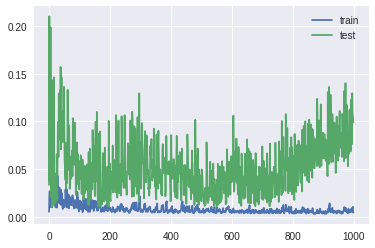

In [40]:
history = model.fit(train_X, train_y, epochs=1000, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [41]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3963.160
